In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import math

import datetime
import pandas as pd
import seaborn as sns
import tensorflow as tf

from opt_weights import *
from model_inputs import *
from constructions import *
from tests.gen_data import *
from model import *

SyntaxError: invalid syntax (model.py, line 133)

notes:
- use this as guide: 
https://tensorflow.googlesource.com/tensorflow/+/master/tensorflow/models/image/mnist/convolutional.py

- autoencode - regularize
- model only has holes when Xs is missing data -build_Xs_from_returns(ret, 10) leads to big holes
- add function to combine different signals (momentum, value, prev returns) 
  - shold allow for returning 2d or 1d
- add convolution layer to build common up/dn forecast
- add check for holes in Xs
- incorporate vol and cash factors, and possibly turnover as a signal
- how can you incorporate coviance with a convolution layer - can you add data in after first layer? 
- add more name scopes (with tf.name_scope('xent')) as done in mnist_with_summaries
- toggle relu - decide good way to set random initialized params
- confirm all ones as input allows perfect fit to train data
- should there be a penalty in final layer?
- shold there be drop out rates?
-  hwo to tell model how to handle 2d vs 1d input Xs
-  code should make clear that it works because all conve layers span width of entire Xs row
- add in funcitonality to test on test data too
- add validation - if input is 2d, must provide convolution structure
- add non relu support for conv layer
- add non connected support for soft max - approximate logistic regression
- confirm a conv layer on uncnoonected soft max beats non conv
- show trian progress for test and train sets
- output model weights


issues:
- optimal weights don't always beat out equal weights, but they should
- with opt weights, understand why top ticker in a period is selected - does max weight ticker tend to have highest return in that period

In [2]:
import pandas.io.data as web
start_date = datetime.date(2005,1,1)
end_date = datetime.date(2012,5,1)
#tickers = ["^GSPC", "^DJI", "^IXIC", "^FCHI", "^FTSE", "^N225"]
tickers = ['GOOG', 'JPM', 'XOM', 'DIS', 'PFE', 'WMT']
px = web.DataReader(tickers, 'yahoo', start_date, end_date).Close
ret = px.div(px.shift()).dropna()
#ret = pd.read_csv('tests/test_data/returns.csv', parse_dates=['Date'], index_col=0)

/Users/ryanchouck/dev/tf/venv/lib/python2.7/site-packages/pandas/io/data.py:35: FutureWarning: 
The pandas.io.data module is moved to a separate package (pandas-datareader) and will be removed from pandas in a future version.
After installing the pandas-datareader package (https://github.com/pydata/pandas-datareader), you can change the import ``from pandas.io import data, wb`` to ``from pandas_datareader import data, wb``.
  FutureWarning)


In [3]:
# risk = .2
# scaler = risk / (ret.std() * math.sqrt(250.))
# ret = ((ret - 1.) * scaler).applymap(lambda x: x + 1.)

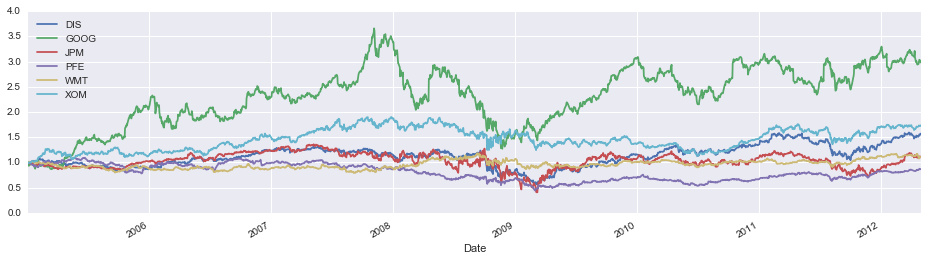

In [4]:
ret.cumprod().plot(figsize=[16,4])

find optimal target regression parameters

In [5]:
#grid = cum_prod_grid(ret, np.exp(np.linspace(-20, 1, 5)), look_ahead_pers=xrange(1,32,10))
#grid[grid.norm_type==2].pivot(index='alpha', columns='look_ahead_per', values='cum_ret')

prep model inputs

In [46]:
opt_weights_func = lambda x: calc_opt_weights(x, alpha=1.426423e-02, norm_type=2)
opt_weights = rolling_fit_opt_weights(ret, opt_weights_func, 31)
ys = pd.DataFrame(opt_weights.values, index=opt_weights.index, columns=opt_weights.columns)

In [47]:
peak = get_peak_ahead_returns(ret, 20)
rands = gen_random_normal(ys.index, 10)
f = lambda x: flatten_df(get_multi_freq_historical_returns(x, 2))
rec_ret2_flat = map_to_date(ret, '2007-1-1', f)
f = lambda x: get_multi_freq_historical_returns(x, 2)
rec_ret2 = map_to_date(ret, '2007-1-1', f)
cov = map_to_date(ret, '2007-1-1', get_flat_cov_matrix)
mom = get_momentum(ret, 6*30)
val = get_value(ret, 6*30)
#mom, val = map(lambda x: xs_score(x), [mom, val])

In [48]:
#Xs = pd.concat([rands], axis=1).dropna()
#Xs = pd.concat([rec_ret2_flat, cov, mom, val], axis=1).dropna()
#Xs = pd.concat([ys, cov, mom, val], axis=1).dropna()
Xs = pd.concat([peak, cov, mom, val], axis=1).dropna()
#Xs = create_2d_features(ret.index,  [rec_ret2, mom, val])

In [49]:
print Xs.shape, ys.shape
Xs, ys = validate_and_format_Xs_ys(Xs, ys)
train, test = split_inputs_by_date(Xs, ys, datetime.date(2200,1,1), buffer_days=1)
Xs_train, ys_train = train[0].values, train[1].values 
print Xs_train.shape, ys_train.shape

(1323, 39) (1814, 6)
(1312, 39) (1312, 6)


In [321]:
# def check_kernel_predictive_accuracy(Xs, ys, true_weights):
#     """apply kernel to Xs and return correct prediction accuracy"""
#     weights_df = pd.DataFrame(np.array([true_weights,]*Xs.shape[1]), index=Xs.major_axis, columns=Xs.minor_axis)
#     scaled = Xs.multiply(weights_df)

#     def get_max_ind(df):
#         x = list(df.sum(axis=1).values)
#         return x.index(max(x))

#     df = pd.DataFrame({'xs': pd.Series([get_max_ind(scaled[item]) for item in scaled.items], index=ys.index),
#                        'ys': ys.apply(lambda x: list(x).index(max(x)), axis=1)})
#     matches = df.apply(lambda x: x[0]==x[1], axis=1)
#     return float(matches.sum()) / matches.shape[0]

In [368]:
dti = pd.DatetimeIndex(start='2000-1-1', freq='B', periods=1000)
Xs, ys, _ = gen_2d_random_Xs_onehot_ys_from_random_kernel(dti, num_classes=15, num_features=10, noise_sigma=10.)
train_inps, test_inps = split_inputs_by_date(Xs, ys, datetime.date(2003,1,1), buffer_days=0)
Xs_train, ys_train = train_inps
Xs_test, ys_test = test_inps
Xs_train_f = flatten_panel(Xs_train).values.astype(np.float32)
Xs_test_f = flatten_panel(Xs_test).values.astype(np.float32)
Xs_train = Xs_train.astype(np.float32).values
Xs_test = Xs_test.astype(np.float32).values
ys_train = ys_train.values
ys_test = ys_test.values
# Xs_train_2 = Xs.values.astype(np.float32)
# #Xs_train_2f = flatten_panel(Xs).values.astype(np.float32)
# ys_train_2 = ys.values
# print Xs_train_2[0].shape

In [365]:
check_kernel_predictive_accuracy(Xs, ys, _)

0.331

n hidden layers with softmax

In [376]:
from model import *
log_path = '/Users/ryanchouck/dev/tf/data/tensor_board'
clear_path(log_path)
structure = [[],[]]
probs, labels, stats = train_nn_softmax([Xs_train_f, Xs_test_f], [ys_train, ys_test], structure, 1000, 100, .1, penalty_alpha=0.)

step     0:	train loss: 3.01	test loss: 3.10		(0.04 sec)
step   100:	train loss: 1.47	test loss: 2.47		(0.27 sec)
step   200:	train loss: 0.97	test loss: 2.48		(0.49 sec)
step   300:	train loss: 0.91	test loss: 2.56		(0.80 sec)
step   400:	train loss: 0.71	test loss: 2.70		(1.01 sec)
step   500:	train loss: 0.59	test loss: 2.85		(1.23 sec)
step   600:	train loss: 0.65	test loss: 2.98		(1.45 sec)
step   700:	train loss: 0.54	test loss: 3.11		(1.67 sec)
step   800:	train loss: 0.47	test loss: 3.23		(1.89 sec)
step   900:	train loss: 0.40	test loss: 3.34		(2.11 sec)
accuracy:	0.954023003578
cross entropy:	0.423647403717


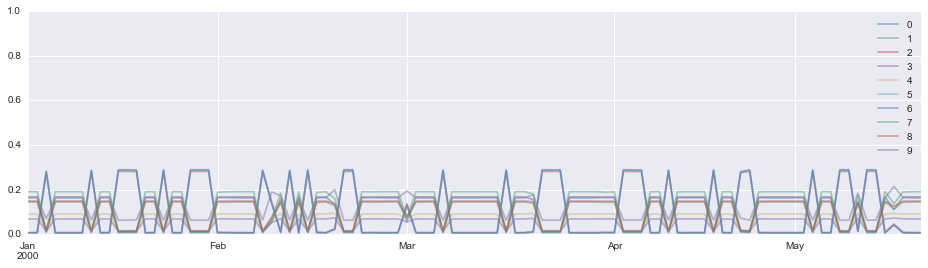

In [61]:
probs = pd.DataFrame(probs, columns=ys.columns, index=ys.index)
probs.plot(figsize=[16,4], ylim=[0,1], alpha=.5)

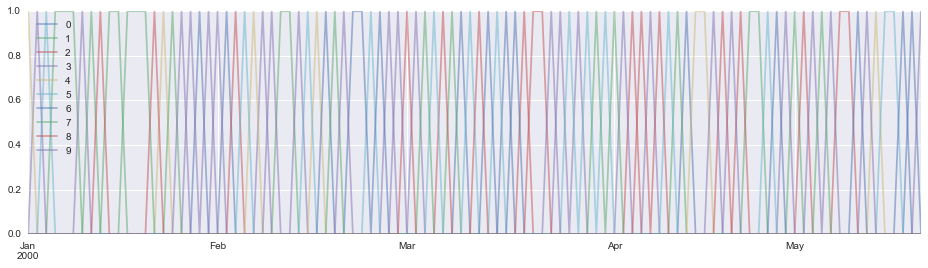

In [156]:
ys.plot(figsize=[16,4], ylim=[0,1], alpha=.5)

In [14]:
cols = list(ys.columns)
cols = dict(map(lambda x: (cols.index(x), x), cols))
labels = pd.Series(labels).map(lambda x: cols[x])
print('predicted max columns:')
print labels.value_counts()
print
print('actual max columns:')
print ys.apply(lambda x: list(x).index(max(x)), axis=1).map(lambda x: cols[x]).value_counts()

predicted max columns:
WMT     1073
PFE       96
DIS       95
GOOG      28
JPM       17
XOM        3
dtype: int64

actual max columns:
WMT     937
PFE     167
XOM      83
GOOG     82
DIS      34
JPM       9
dtype: int64


analytics

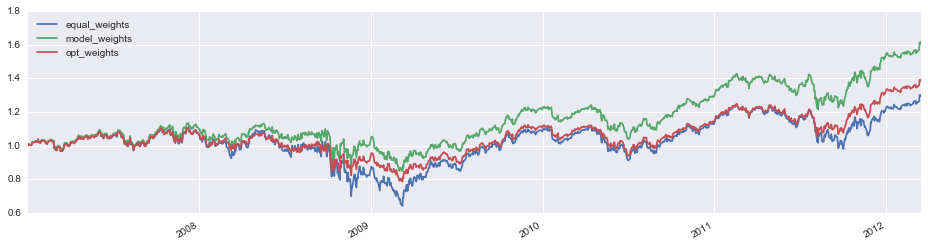

In [15]:
equal_weights = pd.Series({k: 1./ret.shape[1] for k in ret.columns})
perf = pd.DataFrame({'equal_weights': ret.mul(equal_weights).sum(axis=1),
                     'opt_weights': ret.mul(opt_weights).sum(axis=1),
                     'model_weights': ret.mul(probs).sum(axis=1)
                    })
perf.ix[Xs.index].cumprod().plot(figsize=[16,4])